In [ ]:
!git clone https://github.com/sosamandara/token_reduction_nlp.git

Cloning into 'token_reduction_nlp'...
remote: Enumerating objects: 113, done.
remote: Counting objects: 100% (113/113), done.
remote: Compressing objects: 100% (90/90), done.
remote: Total 113 (delta 34), reused 92 (delta 19), pack-reused 0
Receiving objects: 100% (113/113), 2.81 MiB | 12.62 MiB/s, done.
Resolving deltas: 100% (34/34), done.


In [ ]:
%cd /content/token_reduction_nlp/notebooks

/content/token_reduction_nlp/notebooks


In [3]:
import sys
import os

# Get the current working directory
current_dir = os.getcwd()

# Assuming the notebooks are in the notebooks directory and executed from there
project_root = os.path.abspath(os.path.join(current_dir, '..'))

# Add the models and src directories to the Python path
models_dir = os.path.join(project_root, 'models')
src_dir = os.path.join(project_root, 'src')

sys.path.append(models_dir)
sys.path.append(src_dir)

# Verify that the paths are correctly added
print("Current directory:", current_dir)
print("Project root directory:", project_root)
print("Models directory added to sys.path:", models_dir in sys.path)
print("Src directory added to sys.path:", src_dir in sys.path)

Current directory: d:\TESI\token_reduction_nlp\notebooks
Project root directory: d:\TESI\token_reduction_nlp
Models directory added to sys.path: True
Src directory added to sys.path: True


In [4]:
!pip install datasets
from transformers import GPT2Tokenizer, GPT2LMHeadModel, GPT2Config
from modeling_topK_gpt2 import CustomGPT2LMHeadModel
from collections import defaultdict
import matplotlib.pyplot as plt
from datasets import load_dataset
from perplexity import evaluate_perplexity_with_window, evaluate_and_save_perplexities, recalculate_and_plot_perplexities

d:\Conda\Lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [6]:
def calculate_reduction(lenght, mask):
  actual_lenght=lenght
  for percentage in mask:
    actual_lenght = (actual_lenght - int(actual_lenght*percentage))
  return actual_lenght + 1

window_sizes = [50, 100, 200, 300, 500, 1000]
remaining_tokens = []
per_reduction = []
mask = [0.0, 0.0, 0.0, 0.2, 0.2, 0.15, 0.1, 0.1, 0.05, 0.05, 0.0, 0.05]
for w in window_sizes:
  remaining_tokens.append(calculate_reduction(w, mask))

  per_reduction.append(round(calculate_reduction(w, mask)/w,2))
  #per_reduction.append(round(1-round(calculate_reduction(w, mask)/w,2),2))
print(remaining_tokens)
per_reduction

[22, 40, 79, 117, 191, 381]


[0.44, 0.4, 0.4, 0.39, 0.38, 0.38]

In [7]:
def calculate_reduction(lenght, mask):
  actual_lenght=lenght
  for percentage in mask:
    actual_lenght = (actual_lenght - int(actual_lenght*percentage))
  return actual_lenght + 1

window_sizes = [50, 100, 200, 300, 500, 1000]
remaining_tokens = []
per_keep = []

mask_10 = [0.0, 0.15, 0.2, 0.2, 0.25, 0.25, 0.25, 0.25, 0.25, 0.2, 0.05, 0.05]
mask_20 = [0.0, 0.0, 0.25, 0.2, 0.2, 0.2, 0.2, 0.2, 0.1, 0.1, 0.0, 0.05]
#mask_25 = [0.0, 0.0, 0.2, 0.2, 0.2, 0.15, 0.2, 0.2, 0.05, 0.05, 0.0, 0.05]
mask_30 = [0.0, 0.0, 0.2, 0.15, 0.15, 0.15, 0.2, 0.2, 0.05, 0.05, 0.0, 0.0]
mask_40 = [0.0, 0.0, 0.0, 0.2, 0.2, 0.15, 0.1, 0.1, 0.05, 0.05, 0.0, 0.05]
mask_50 = [0.0, 0.0, 0.0, 0.2, 0.15, 0.07, 0.07, 0.1, 0.05, 0.05, 0.0, 0.0]
mask_60 = [0.0, 0.0, 0.07, 0.07, 0.1, 0.07, 0.07, 0.05, 0.05, 0.05, 0.0, 0.0]
mask_70 = [0.0, 0.0, 0.05, 0.07, 0.1, 0.07, 0.05, 0.0, 0.0, 0.05, 0.0, 0.0]
mask_80 = [0.0, 0.0, 0.0, 0.05, 0.05, 0.05, 0.05, 0.05, 0.0, 0.0, 0.0, 0.0]
mask_90 = [0.0, 0.0, 0.0, 0.05, 0.0, 0.05, 0.0, 0.03, 0.0, 0.0, 0.0, 0.0]

masks = [mask_10, mask_20, mask_30, mask_40, mask_50,
         mask_60, mask_70, mask_80, mask_90,]
mask_number = ["10", "20", "30", "40", "50", "60", "70", "80", "90"]

for i, mask in enumerate(masks):
  #remaining_tokens = []
  per_keep = []
  for w in window_sizes:
    #remaining_tokens.append(calculate_reduction(w, mask))
    per_keep.append(round(calculate_reduction(w, mask)/w,2))
    #print(remaining_tokens)
  print("-----",mask_number[i],"-----")
  print(per_keep)

----- 10 -----
[0.14, 0.13, 0.1, 0.1, 0.1, 0.1]
----- 20 -----
[0.24, 0.22, 0.2, 0.2, 0.19, 0.19]
----- 30 -----
[0.34, 0.31, 0.29, 0.3, 0.29, 0.29]
----- 40 -----
[0.44, 0.4, 0.4, 0.39, 0.38, 0.38]
----- 50 -----
[0.52, 0.51, 0.49, 0.49, 0.48, 0.48]
----- 60 -----
[0.68, 0.61, 0.59, 0.59, 0.58, 0.58]
----- 70 -----
[0.76, 0.71, 0.68, 0.68, 0.67, 0.67]
----- 80 -----
[0.82, 0.8, 0.79, 0.78, 0.78, 0.78]
----- 90 -----
[0.92, 0.9, 0.89, 0.88, 0.88, 0.88]


In [ ]:
model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
config = GPT2Config.from_pretrained(model_name)
model_gpt = GPT2LMHeadModel.from_pretrained(model_name, config=config)
model_gpt.to('cuda')

#mask_10 10 is the total keep rate
########
########
topK_10 = CustomGPT2LMHeadModel.from_pretrained(model_name, config=config, k_percent=mask_10,
                                                layers_to_prune=[0, 1, 2,3, 4, 5, 6,7,8,9,10,11])
topK_10.to('cuda')
########
########
topK_20 = CustomGPT2LMHeadModel.from_pretrained(model_name, config=config, k_percent=mask_20,
                                                layers_to_prune=[0, 1, 2,3, 4, 5, 6,7,8,9,10,11])
topK_20.to('cuda')
########
#topK_25 = CustomGPT2LMHeadModel.from_pretrained(model_name, config=config, k_percent=mask_25,
#                                                layers_to_prune=[0, 1, 2,3, 4, 5, 6,7,8,9,10,11])
#topK_25.to('cuda')
########
########
topK_30 = CustomGPT2LMHeadModel.from_pretrained(model_name, config=config, k_percent=mask_30,
                                                layers_to_prune=[0, 1, 2,3, 4, 5, 6,7,8,9,10,11])
topK_30.to('cuda')
########
########
topK_40 = CustomGPT2LMHeadModel.from_pretrained(model_name, config=config, k_percent=mask_40,
                                                layers_to_prune=[0, 1, 2,3, 4, 5, 6,7,8,9,10,11])
topK_40.to('cuda')
########
########
topK_50 = CustomGPT2LMHeadModel.from_pretrained(model_name, config=config, k_percent=mask_50,
                                                layers_to_prune=[0, 1, 2,3, 4, 5, 6,7,8,9,10,11])
topK_50.to('cuda')
########
########
topK_60 = CustomGPT2LMHeadModel.from_pretrained(model_name, config=config, k_percent=mask_60,
                                                layers_to_prune=[0, 1, 2,3, 4, 5, 6,7,8,9,10,11])
topK_60.to('cuda')
########
########
topK_70 = CustomGPT2LMHeadModel.from_pretrained(model_name, config=config, k_percent=mask_70,
                                                layers_to_prune=[0, 1, 2,3, 4, 5, 6,7,8,9,10,11])
topK_70.to('cuda')
########
########
topK_80 = CustomGPT2LMHeadModel.from_pretrained(model_name, config=config, k_percent=mask_80,
                                                layers_to_prune=[0, 1, 2,3, 4, 5, 6,7,8,9,10,11])
topK_80.to('cuda')
########
########
topK_90 = CustomGPT2LMHeadModel.from_pretrained(model_name, config=config, k_percent=mask_90,
                                                layers_to_prune=[0, 1, 2,3, 4, 5, 6,7,8,9,10,11])
topK_90.to('cuda')

In [ ]:
test = load_dataset("wikitext", "wikitext-2-raw-v1", split="test")
encodings = tokenizer("\n\n".join(test["text"]), return_tensors="pt")

In [ ]:
window_sizes = [50, 100, 200, 300, 500, 1000]
models = [model_gpt, topK_10, topK_20, topK_30, topK_40, topK_50, topK_60, topK_70, topK_80, topK_90]
model_names = ['gpt2', 'custom_10%', 'custom_20%', 'custom_20%', 'custom_40%', 'custom_50%', 'custom_60%', 'custom_70%', 'custom_80%', 'custom_90%']
output_dir = 'results'

evaluate_and_save_perplexities(models, model_names, encodings, window_sizes, output_dir)

# Load from results folder

Saved recalculated perplexities for gpt2 to d:\TESI\token_reduction_nlp\results/Mean_Attention_Removal\recalculated_perplexities_gpt2.csv
Saved recalculated perplexities for custom_20% to d:\TESI\token_reduction_nlp\results/Mean_Attention_Removal\recalculated_perplexities_custom_20%.csv
Saved recalculated perplexities for custom_30% to d:\TESI\token_reduction_nlp\results/Mean_Attention_Removal\recalculated_perplexities_custom_30%.csv
Saved recalculated perplexities for custom_40% to d:\TESI\token_reduction_nlp\results/Mean_Attention_Removal\recalculated_perplexities_custom_40%.csv
Saved recalculated perplexities for custom_50% to d:\TESI\token_reduction_nlp\results/Mean_Attention_Removal\recalculated_perplexities_custom_50%.csv
Saved recalculated perplexities for custom_60% to d:\TESI\token_reduction_nlp\results/Mean_Attention_Removal\recalculated_perplexities_custom_60%.csv
Saved recalculated perplexities for custom_70% to d:\TESI\token_reduction_nlp\results/Mean_Attention_Removal\rec

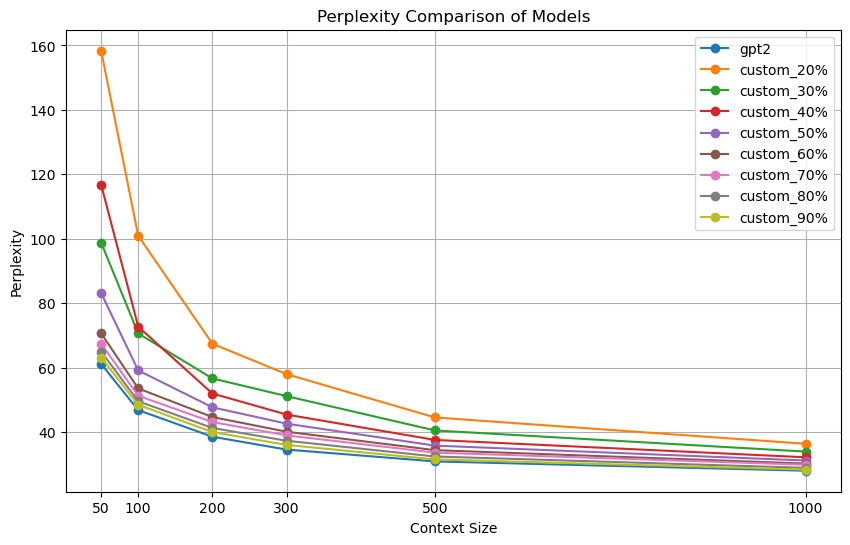

Recalculated perplexities and plot saved to d:\TESI\token_reduction_nlp\results/Mean_Attention_Removal


In [9]:
# Example usage
window_sizes = [50, 100, 200, 300, 500, 1000]
#model_names = ['gpt2', 'custom_10%', 'custom_25%', 'custom_40%', 'custom_50%', 'custom_60%', 'custom_70%', 'custom_80%', 'custom_90%']
#model_names = ['gpt2', 'custom_25%', 'custom_40%', 'custom_50%', 'custom_60%', 'custom_70%', 'custom_80%', 'custom_90%']
model_names = ['gpt2', 'custom_20%', 'custom_30%', 'custom_40%', 'custom_50%', 'custom_60%', 'custom_70%', 'custom_80%', 'custom_90%']
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
output_dir = os.path.join(project_root, 'results/Mean_Attention_Removal')

recalculate_and_plot_perplexities(window_sizes, model_names, output_dir)

In [ ]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def setup_paths():
    current_dir = os.getcwd()
    if 'content' in current_dir:
        # Running in Colab
        project_root = os.path.abspath(os.path.join(current_dir, '..'))
    else:
        # Running locally
        project_root = os.path.abspath(os.path.join(current_dir, '..'))

    models_dir = os.path.join(project_root, 'models')
    src_dir = os.path.join(project_root, 'src')
    results_dir = os.path.join(project_root, 'results')

    sys.path.append(models_dir)
    sys.path.append(src_dir)

    print("Current directory:", current_dir)
    print("Project root directory:", project_root)
    print("Models directory added to sys.path:", models_dir in sys.path)
    print("Src directory added to sys.path:", src_dir in sys.path)

    return results_dir

def recalculate_and_plot_perplexities(window_sizes, model_names, output_dir):
    """
    Recalculate perplexities from log probabilities, save to CSV, and plot the results.

    :param window_sizes: List of window sizes to evaluate
    :param model_names: List of names corresponding to the models
    :param output_dir: Directory to save the results
    """
    # Ensure the output directory exists
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Initialize dictionary to store the recalculated perplexities
    recalculated_perplexities = {model_name.replace('custom', 'topK'): [] for model_name in model_names}

    # Function to calculate perplexity from log probabilities
    def calculate_perplexity(log_probs):
        avg_log_prob = np.mean(log_probs)
        perplexity = np.exp(-avg_log_prob)
        return perplexity

    # Recalculate perplexities for each model and window size
    for model_name in model_names:
        model_name_topK = model_name.replace('custom', 'topK')
        for window_size in window_sizes:
            log_probs_filename = f'log_probs_{model_name}_window_{window_size}.csv'
            log_probs_path = os.path.join(output_dir, log_probs_filename)

            if not os.path.exists(log_probs_path):
                # Check alternative naming patterns
                if model_name == 'gpt2':
                    log_probs_filename = f'log_probs_gpt2_window_{window_size}.csv'
                else:
                    log_probs_filename = f'log_probs_custom_window_{window_size}.csv'

                log_probs_path = os.path.join(output_dir, log_probs_filename)

                if not os.path.exists(log_probs_path):
                    print(f"File not found: {log_probs_path}")
                    continue

            log_probs = pd.read_csv(log_probs_path)['log_probs'].tolist()
            perplexity = calculate_perplexity(log_probs)
            recalculated_perplexities[model_name_topK].append(perplexity)

        if len(recalculated_perplexities[model_name_topK]) == 0:
            print(f"No data found for model {model_name_topK}. Skipping.")
            del recalculated_perplexities[model_name_topK]

    # Save recalculated perplexities to CSV
    for model_name in recalculated_perplexities.keys():
        if len(recalculated_perplexities[model_name]) != len(window_sizes):
            print(f"Warning: Not all window sizes have data for model {model_name}. Skipping save.")
            continue
        df_recalculated = pd.DataFrame({
            'window_size': window_sizes,
            'perplexity': recalculated_perplexities[model_name]
        })
        output_path = os.path.join(output_dir, f'recalculated_perplexities_{model_name}.csv')
        df_recalculated.to_csv(output_path, index=False)
        print(f"Saved recalculated perplexities for {model_name} to {output_path}")

    # Plotting the results
    plt.figure(figsize=(12, 8))
    for model_name, perplexities in recalculated_perplexities.items():
        plt.plot(window_sizes, perplexities, label=model_name, marker='o')
    plt.xticks(window_sizes)  # Ensure x-axis has the correct window sizes as ticks
    plt.xlabel("Context Size (tokens)", fontsize=14)
    plt.ylabel("Perplexity", fontsize=14)
    plt.title("Perplexity Comparison of Models", fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()

    # Save the plot to a file
    plot_path = os.path.join(output_dir, 'recalculated_perplexity_comparison_plot.png')
    plt.savefig(plot_path)
    plt.show()

    print(f"Recalculated perplexities and plot saved to {output_dir}")

    # Return recalculated_perplexities for further use
    return recalculated_perplexities

# Set up paths and run the function
results_dir = setup_paths()

window_sizes = [50, 100, 200, 300, 500, 1000]
model_names = ['gpt2','custom_10%', 'custom_20%', 'custom_30%', 'custom_40%', 'custom_50%', 'custom_60%', 'custom_70%', 'custom_80%', 'custom_90%']
output_dir = results_dir

# Recalculate perplexities and get the results
recalculated_perplexities = recalculate_and_plot_perplexities(window_sizes, model_names, output_dir)

# Plotting functions

def plot_bar_perplexities(window_sizes, recalculated_perplexities, model_names, output_dir):
    df = pd.DataFrame(recalculated_perplexities, index=window_sizes)
    df.plot(kind='bar', figsize=(12, 8))
    plt.xlabel("Context Size (tokens)", fontsize=14)
    plt.ylabel("Perplexity", fontsize=14)
    plt.title("Perplexity Comparison of Models", fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()

    # Save the plot to a file
    plot_path = os.path.join(output_dir, 'bar_perplexity_comparison_plot.png')
    plt.savefig(plot_path)
    plt.show()
    print(f"Bar plot saved to {plot_path}")

def plot_box_perplexities(window_sizes, recalculated_perplexities, model_names, output_dir):
    df = pd.DataFrame(recalculated_perplexities, index=window_sizes)
    df.plot(kind='box', figsize=(12, 8))
    plt.xlabel("Models", fontsize=14)
    plt.ylabel("Perplexity", fontsize=14)
    plt.title("Perplexity Distribution Across Models", fontsize=16)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()

    # Save the plot to a file
    plot_path = os.path.join(output_dir, 'box_perplexity_comparison_plot.png')
    plt.savefig(plot_path)
    plt.show()
    print(f"Box plot saved to {plot_path}")

def plot_heatmap_perplexities(window_sizes, recalculated_perplexities, model_names, output_dir):
    df = pd.DataFrame(recalculated_perplexities, index=window_sizes)
    plt.figure(figsize=(12, 8))
    sns.heatmap(df, annot=True, cmap="YlGnBu", cbar=True)
    plt.xlabel("Models", fontsize=14)
    plt.ylabel("Context Size (tokens)", fontsize=14)
    plt.title("Heatmap of Perplexity Across Models and Context Sizes", fontsize=16)
    plt.tight_layout()

    # Save the plot to a file
    plot_path = os.path.join(output_dir, 'heatmap_perplexity_comparison_plot.png')
    plt.savefig(plot_path)
    plt.show()
    print(f"Heatmap saved to {plot_path}")

def plot_scatter_perplexities(window_sizes, recalculated_perplexities, model_names, output_dir):
    plt.figure(figsize=(12, 8))
    for model_name in model_names:
        model_name_topK = model_name.replace('custom', 'topK')
        if model_name_topK in recalculated_perplexities:
            plt.scatter(window_sizes, recalculated_perplexities[model_name_topK], label=model_name_topK)
            sns.regplot(x=window_sizes, y=recalculated_perplexities[model_name_topK], label=model_name_topK, scatter=False)
    plt.xticks(window_sizes)
    plt.xlabel("Context Size (tokens)", fontsize=14)
    plt.ylabel("Perplexity", fontsize=14)
    plt.title("Scatter Plot with Regression Line for Perplexity", fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()

    # Save the plot to a file
    plot_path = os.path.join(output_dir, 'scatter_perplexity_comparison_plot.png')
    plt.savefig(plot_path)
    plt.show()
    print(f"Scatter plot saved to {plot_path}")

# Generate additional plots
plot_bar_perplexities(window_sizes, recalculated_perplexities, model_names, output_dir)
plot_box_perplexities(window_sizes, recalculated_perplexities, model_names, output_dir)
plot_heatmap_perplexities(window_sizes, recalculated_perplexities, model_names, output_dir)
plot_scatter_perplexities(window_sizes, recalculated_perplexities, model_names, output_dir)
